✅ Loading GT descriptors from results/descriptors_gt.pkl

Processing 00000.jpg ...


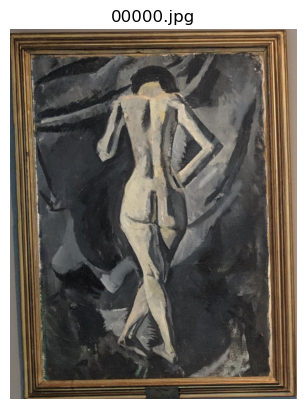


Processing 00001.jpg ...


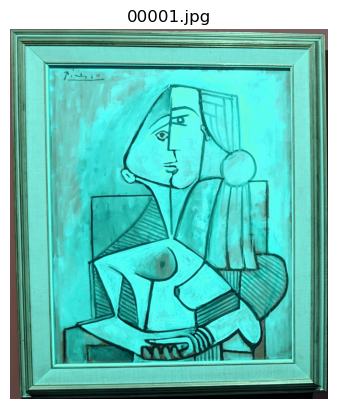


Processing 00002.jpg ...


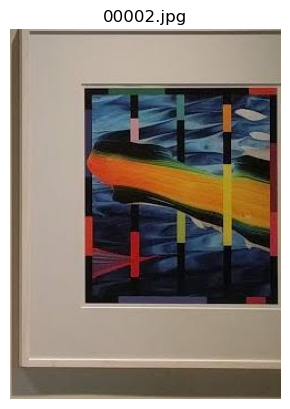


Processing 00003.jpg ...


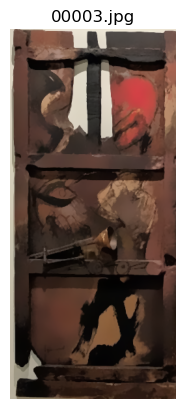


Processing 00004.jpg ...


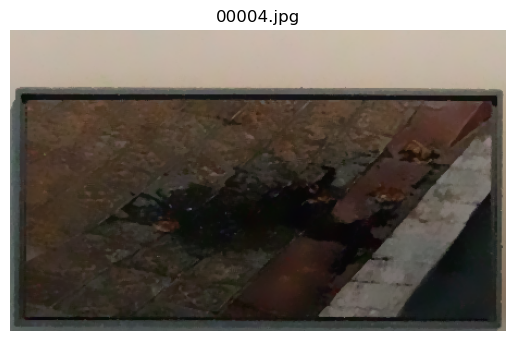


Processing 00005.jpg ...


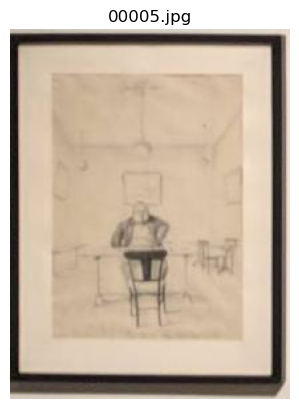


Processing 00006.jpg ...


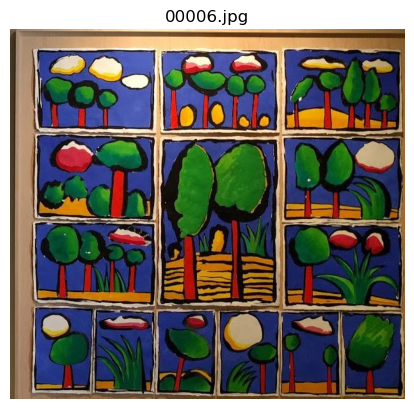


Processing 00007.jpg ...


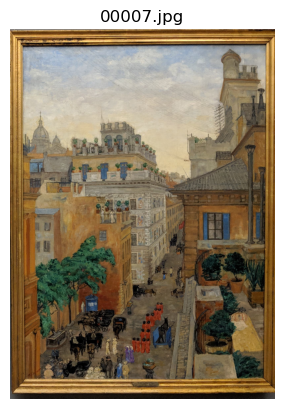


Processing 00008.jpg ...


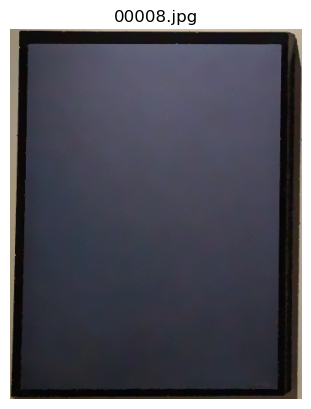


Processing 00009.jpg ...


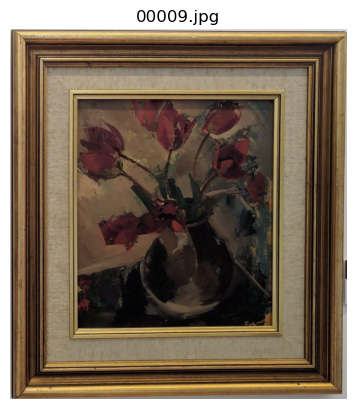


Processing 00010.jpg ...


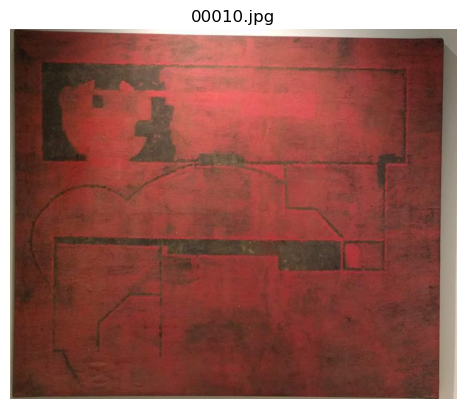


Processing 00011.jpg ...


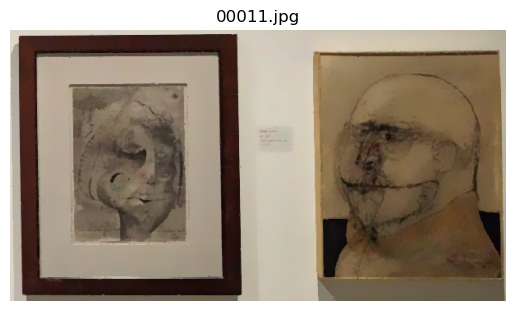


Processing 00012.jpg ...


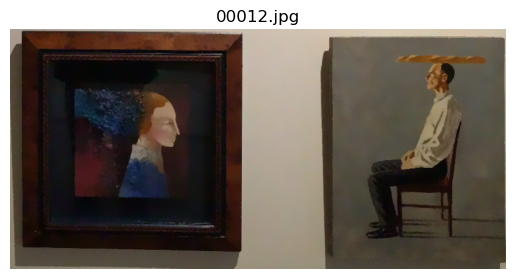


Processing 00013.jpg ...


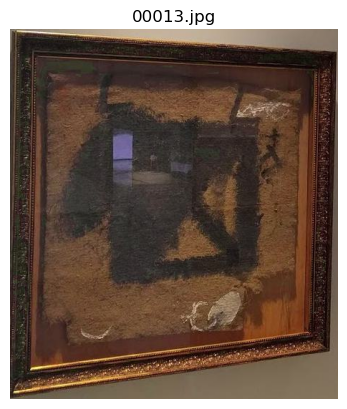


Processing 00014.jpg ...


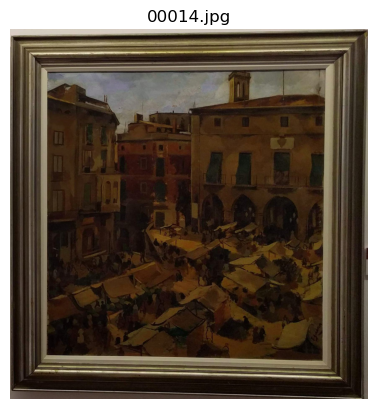


Processing 00015.jpg ...


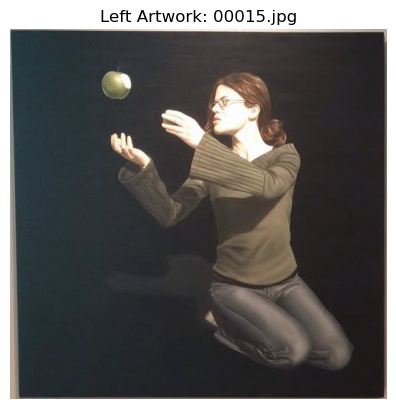

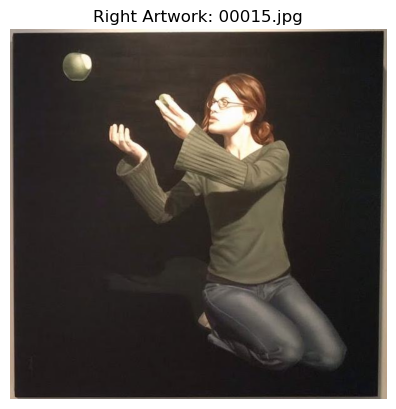


Processing 00016.jpg ...


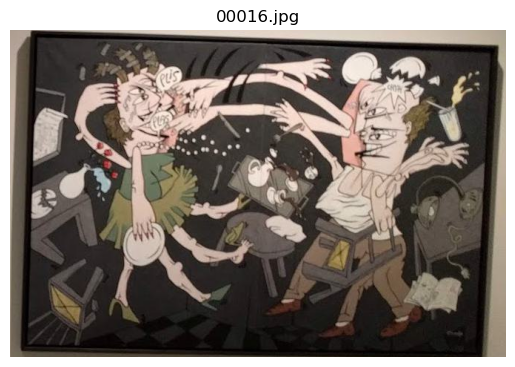


Processing 00017.jpg ...


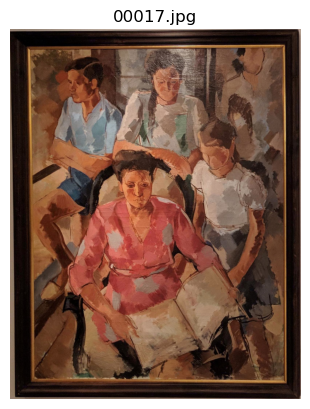


Processing 00018.jpg ...


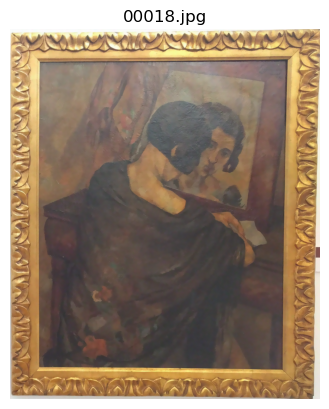


Processing 00019.jpg ...


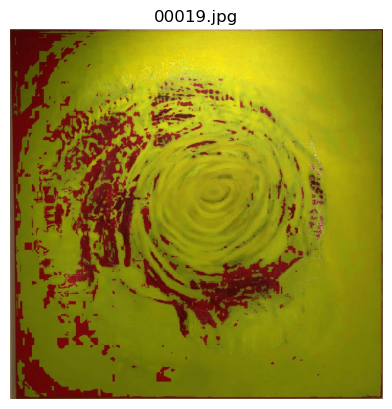


Processing 00020.jpg ...


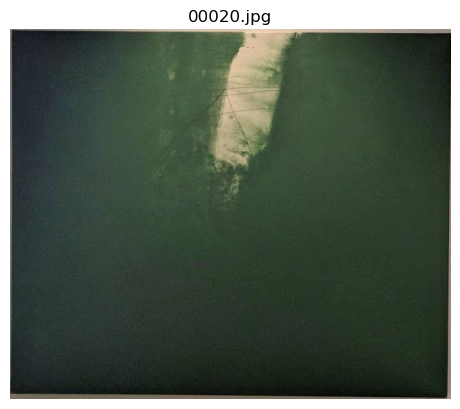


Processing 00021.jpg ...


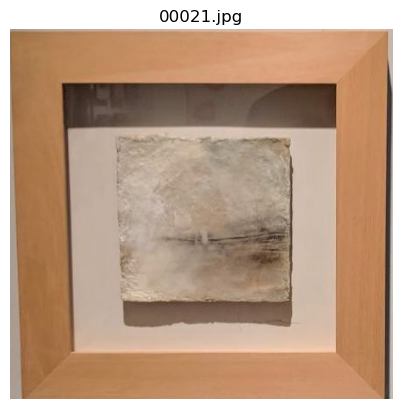


Processing 00022.jpg ...


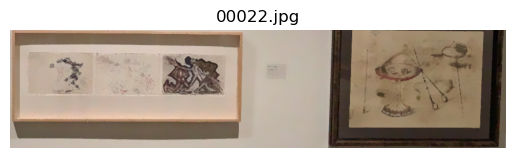


Processing 00023.jpg ...


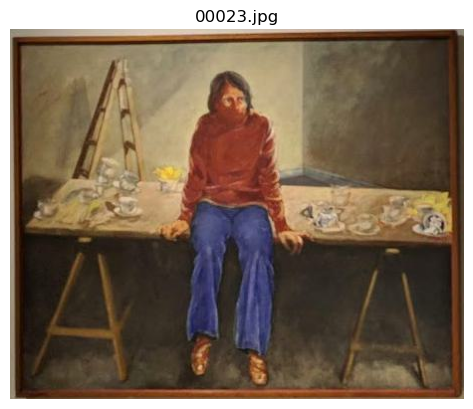


Processing 00024.jpg ...


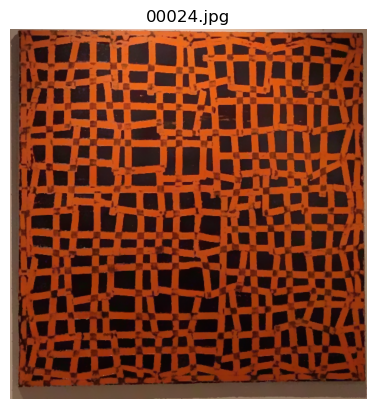


Processing 00025.jpg ...


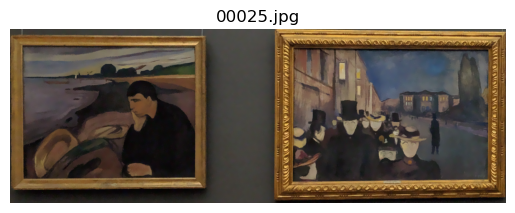


Processing 00026.jpg ...


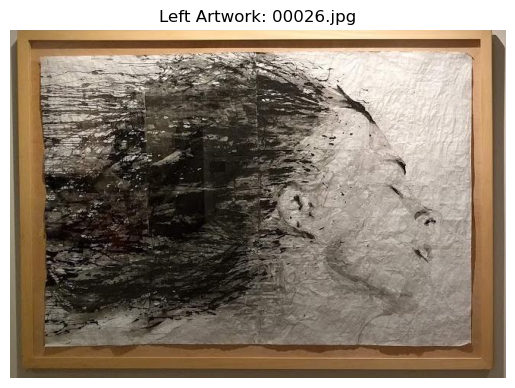

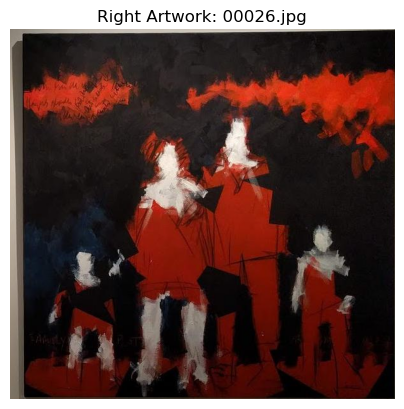


Processing 00027.jpg ...


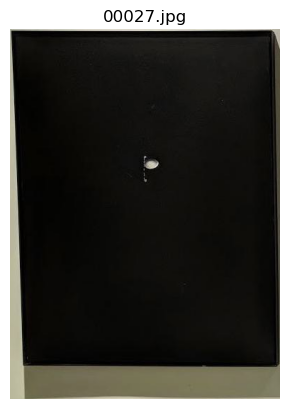


Processing 00028.jpg ...


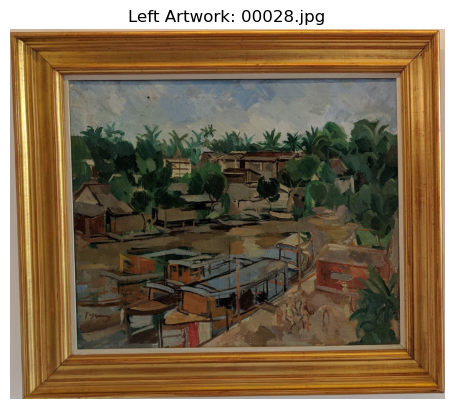

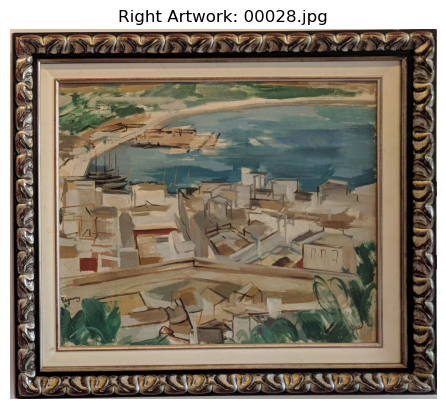


Processing 00029.jpg ...


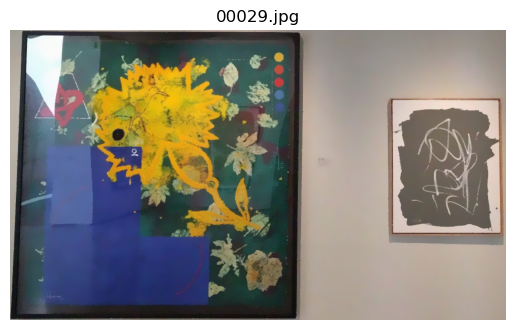


✅ Saved top-10 retrieval results to results/qst2_top10_results.pkl


In [1]:
import cv2
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from background_removal_exp import background_remover_w2
from descriptors import preprocess_image, extract_descriptor, extract_descriptors
from image_split import split_images

# Paths
IMG_FOLDER = "../Data/Week3/qst2_w3/"
IMG_FOLDER_GT = "../Data/Week3/BBDD/"
DESC_GT_PATH = "results/descriptors_gt.pkl"
RESULTS_PATH = "results/qst2_top10_results.pkl"

K = 10  # number of best results to retrieve

# --- 1. Load or compute GT descriptors ---
if os.path.exists(DESC_GT_PATH):
    print(f"✅ Loading GT descriptors from {DESC_GT_PATH}")
    with open(DESC_GT_PATH, "rb") as f:
        data = pickle.load(f)
        desc_gt = data["desc_gt"]
        gt_names = data["gt_names"]
else:
    print("🧠 Computing GT descriptors...")
    desc_gt, gt_names = extract_descriptors(IMG_FOLDER_GT, preprocess=False)
    os.makedirs(os.path.dirname(DESC_GT_PATH), exist_ok=True)
    with open(DESC_GT_PATH, "wb") as f:
        pickle.dump({"desc_gt": desc_gt, "gt_names": gt_names}, f)
    print(f"💾 Saved GT descriptors to {DESC_GT_PATH}")


def crop_to_mask_rectangle(image, mask):
    """Crop the image to the rectangular bounding box of the mask (removes black areas)."""
    mask = (mask > 0).astype(np.uint8)
    coords = cv2.findNonZero(mask)
    if coords is None:
        return image  # fallback if mask empty
    x, y, w, h = cv2.boundingRect(coords)
    return image[y:y+h, x:x+w]


# --- 2. Process query images ---
image_names = sorted([f for f in os.listdir(IMG_FOLDER) if f.endswith('.jpg')])
results = []  # list of lists: one (or two) sublists per query image

for img_idx, img_name in enumerate(image_names):
    print(f"\nProcessing {img_name} ...")
    img_path = os.path.join(IMG_FOLDER, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Skipping {img_name}: could not read image.")
        continue

    _,splitted = split_images(img)

    artwork_results = []  # will hold one or two sublists for this image

    # --- Two artworks ---
    if isinstance(splitted, tuple):
        left_artwork, right_artwork = splitted
        for side, art in zip(["Left", "Right"], [left_artwork, right_artwork]):
            art = preprocess_image(art)
            _, mask, output, _ = background_remover_w2.remove_background_morphological_gradient(art)
            cropped = crop_to_mask_rectangle(art, mask)
            desc = extract_descriptor(cropped)

            # Cosine similarity to GT descriptors
            sims = cosine_similarity([desc], desc_gt)[0]
            top_k = np.argsort(-sims)[:K].tolist()
            artwork_results.append(top_k)

            # Optional visualization
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            plt.title(f"{side} Artwork: {img_name}")
            plt.axis("off")
            plt.show()

    # --- One artwork ---
    else:
        img = preprocess_image(splitted)
        _, mask, output, _ = background_remover_w2.remove_background_morphological_gradient(img)
        cropped = crop_to_mask_rectangle(img, mask)
        desc = extract_descriptor(cropped)

        sims = cosine_similarity([desc], desc_gt)[0]
        top_k = np.argsort(-sims)[:K].tolist()
        artwork_results.append(top_k)

        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name}")
        plt.axis("off")
        plt.show()

    results.append(artwork_results)


# --- 3. Save top-10 results ---
os.makedirs(os.path.dirname(RESULTS_PATH), exist_ok=True)
with open(RESULTS_PATH, "wb") as f:
    pickle.dump(results, f)

print(f"\n✅ Saved top-{K} retrieval results to {RESULTS_PATH}")


In [2]:
print(results)

[[[262, 156, 88, 286, 19, 48, 197, 254, 18, 210]], [[108, 236, 36, 116, 49, 1, 280, 221, 147, 84]], [[151, 56, 284, 266, 209, 145, 114, 202, 178, 194]], [[156, 242, 161, 255, 16, 176, 132, 103, 39, 184]], [[241, 255, 184, 221, 243, 207, 194, 1, 269, 263]], [[47, 36, 232, 104, 251, 236, 35, 270, 49, 277]], [[284, 156, 97, 22, 181, 217, 103, 4, 17, 51]], [[193, 177, 217, 44, 253, 164, 97, 4, 22, 182]], [[109, 32, 210, 276, 281, 255, 144, 16, 250, 186]], [[58, 229, 141, 38, 67, 2, 178, 167, 192, 243]], [[109, 274, 250, 210, 16, 186, 18, 276, 161, 107]], [[53, 109, 193, 197, 70, 7, 182, 250, 254, 4]], [[55, 254, 62, 179, 148, 219, 78, 26, 121, 9]], [[280, 236, 164, 1, 250, 221, 100, 108, 36, 201]], [[259, 196, 215, 262, 116, 268, 183, 258, 235, 255]], [[219, 179, 171, 109, 146, 281, 200, 25, 276, 144], [171, 109, 282, 179, 276, 219, 281, 139, 210, 144]], [[144, 276, 281, 210, 167, 255, 109, 164, 16, 181]], [[81, 222, 93, 3, 251, 226, 30, 247, 14, 107]], [[176, 184, 130, 235, 132, 39, 23, 1

[[[262, 156, 48, 19, 286, 197, 88, 6, 210, 18]], [[108, 236, 36, 116, 49, 1, 280, 221, 147, 84]], [[151, 56, 284, 266, 209, 145, 202, 114, 178, 194]], [[156, 242, 161, 255, 16, 176, 132, 103, 39, 184]], [[241, 255, 184, 221, 243, 207, 194, 1, 269, 263]], [[47, 36, 232, 104, 251, 236, 35, 270, 49, 277]], [[284, 156, 97, 4, 22, 217, 17, 181, 51, 57]], [[193, 177, 217, 44, 253, 164, 97, 4, 22, 182]], [[109, 210, 32, 276, 281, 255, 144, 171, 16, 250], [221, 198, 165, 6, 280, 108, 25, 106, 267, 1]], [[58, 229, 141, 38, 67, 2, 178, 167, 192, 243]], [[109, 274, 250, 210, 16, 186, 18, 276, 161, 107]], [[53, 109, 193, 197, 70, 7, 182, 250, 254, 4]], [[55, 254, 62, 179, 148, 219, 78, 26, 121, 9]], [[280, 236, 164, 1, 250, 221, 100, 108, 36, 201]], [[259, 196, 215, 262, 116, 268, 183, 258, 235, 255]], [[124, 53, 72, 82, 129, 224, 197, 79, 3, 19]], [[144, 276, 281, 210, 255, 109, 167, 16, 164, 181]], [[81, 222, 93, 3, 251, 226, 30, 247, 14, 107]], [[176, 184, 130, 235, 132, 39, 23, 156, 94, 262]], [[78, 165, 106, 25, 254, 234, 198, 274, 148, 46]], [[53, 3, 107, 30, 247, 98, 54, 14, 250, 197]], [[100, 1, 221, 177, 16, 280, 164, 250, 97, 194]], [[182, 1, 97, 22, 194, 177, 156, 253, 44, 4], [140, 109, 12, 276, 245, 252, 144, 98, 107, 20]], [[65, 203, 164, 12, 8, 107, 74, 98, 35, 250]], [[97, 1, 186, 255, 181, 161, 22, 194, 210, 221]], [[94, 237, 23, 239, 69, 176, 194, 22, 151, 191], [132, 194, 22, 239, 1, 94, 184, 263, 156, 116]], [[127, 92, 269, 228, 42, 25, 175, 243, 167, 159], [138, 71, 109, 82, 282, 156, 161, 32, 124, 12]], [[15, 138, 139, 39, 228, 171, 213, 76, 176, 126]], [[235, 132, 184, 39, 156, 176, 243, 263, 130, 255], [248, 236, 193, 65, 164, 8, 120, 265, 44, 174]], [[193, 201, 7, 255, 22, 217, 284, 44, 164, 1], [268, 235, 184, 116, 258, 183, 56, 159, 194, 202]]]